# Born & Rytov approximation comparison

Notebook used to compare between the Born and Rytov approximation.

Born approximation assumes: $|U_{scat}| \ll |U_i|$.

Rytov approximation assumes: $(\nabla\phi_{scat}(\vec{r}))^2 \ll f(\vec{r})$.

The two approximations can result in different reconstruction qualities, due to the approximations having different validity ranges. This is tested here using a Mie cylinder of $R=10\lambda$. The refractive index $n_{obj}$ is varried until breakdown occurs. Objects with absorption can be tested here using a complex refractive index for the object.

In [1]:
from generateFieldSingleCylinder import calc_field
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [2]:
lambda0 = 633E-9
R = 10 * lambda0
z0 = R + lambda0

NA = 1

Lx = 8 * R
Ly = 8 * R
Lz = 8 * R

Nx = 160
Ny = 160
Nz = 160

dx = Lx / Nx
dy = Ly / Ny
dz = Lz / Nz

x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)
z = np.linspace(-Lz/2, Lz/2, Nz)

xxx, yyy, zzz = np.meshgrid(x, y, z)
RRR = np.sqrt(xxx**2 + zzz**2)

n_med = 1
k_med = 2 * np.pi * n_med / lambda0
n_obj = 1.025#+0.025j

## Generate scattered field

In [3]:
single_det_image = calc_field(__name__, lambda0, n_med, n_obj, R, Nx, Ny, Lx, Ly, z0)

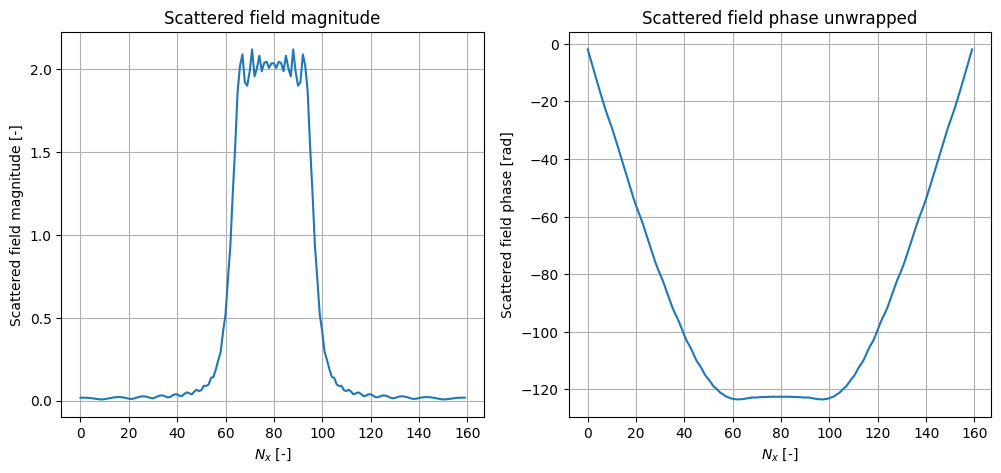

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(np.abs(single_det_image[Nx//2, :]))
ax1.set_xlabel("$N_x$ [-]")
ax1.set_ylabel("Scattered field magnitude [-]")
ax1.title.set_text("Scattered field magnitude")
ax1.grid()

ax2.plot(np.unwrap(np.angle(single_det_image[Nx//2, :])))
ax2.set_xlabel("$N_x$ [-]")
ax2.set_ylabel("Scattered field phase [rad]")
ax2.title.set_text("Scattered field phase unwrapped")
ax2.grid()
plt.show()

## Perform filtered backpropagation

In [5]:
# Setup angles
nproj = 200
theta = np.linspace(0, 2*np.pi , nproj)

# Setup both Born & Rytov sinogram, Rytov sinogram assumes incomming wave being 1.
sinogram_field = np.tile(single_det_image, (nproj, 1, 1))
sinogram_rytov = np.tile(np.emath.log(single_det_image + 1), (nproj, 1, 1))

# Calculate all variables & prefactors needed before performing filtered backpropagation
lambda0_px = lambda0 / dz
lD = z0 / dz

km_px = (2 * np.pi * n_med) / lambda0_px

kx_px = 2 * np.pi * np.fft.fftfreq(Nx)
ky_px = 2 * np.pi * np.fft.fftfreq(Ny)

kx_px = kx_px.reshape(1, -1)
ky_px = ky_px.reshape(-1, 1)

filter_klp_px = (kx_px**2 + ky_px**2 < km_px**2)

M = 1. / km_px * np.sqrt((km_px**2 - kx_px**2 - ky_px**2) * filter_klp_px)

prefactor = -1j * km_px / (2 * np.pi)
prefactor *= 2*np.pi / nproj
prefactor *= np.abs(kx_px) * filter_klp_px
prefactor *= np.exp(-1j * km_px * (M-1) * lD)

zv = z.reshape(-1, 1, 1) / dz

Mp = M.reshape(Ny, Nx)

filter2 = np.exp(1j * zv * km_px * (Mp - 1))

projection_field = np.fft.fft2(sinogram_field, axes=(1,2)) * prefactor / (dx * dy)
projection_rytov = np.fft.fft2(sinogram_rytov, axes=(1,2)) * prefactor / (dx * dy)

interpolation_order = 1

objectFD_field = np.zeros((Nz, Ny, Nx), dtype=complex)
objectFD_rytov = np.zeros((Nz, Ny, Nx), dtype=complex)

# Perform filtered backpropagation (both Born & Rytov)
for i in tqdm(range(nproj)):
    
    rotated_projection_field = np.zeros((Nz, Ny, Nx), dtype="complex64")
    rotated_projection_rytov = np.zeros((Nz, Ny, Nx), dtype="complex64")

    for p in range(len(zv)):
        rotated_projection_field[p, :, :] = np.fft.ifft2(projection_field[i] * filter2[p], axes=(0,1))
        rotated_projection_rytov[p, :, :] = np.fft.ifft2(projection_rytov[i] * filter2[p], axes=(0,1))
        
        
    rotated_projection_field = scipy.ndimage.rotate(
        rotated_projection_field, theta[i] * 180 / np.pi,
        reshape=False, mode="constant", cval=0,
        axes=(0, 2), order=interpolation_order)

    rotated_projection_rytov = scipy.ndimage.rotate(
        rotated_projection_rytov, theta[i] * 180 / np.pi,
        reshape=False, mode="constant", cval=0,
        axes=(0, 2), order=interpolation_order)

    objectFD_field += rotated_projection_field
    objectFD_rytov += rotated_projection_rytov

ri_field = n_med * np.sqrt(objectFD_field / k_med**2 + 1)
ri_rytov = n_med * np.sqrt(objectFD_rytov / k_med**2 + 1)

100%|█████████████████████████████████████████| 200/200 [01:33<00:00,  2.15it/s]


## Visualize the comparison

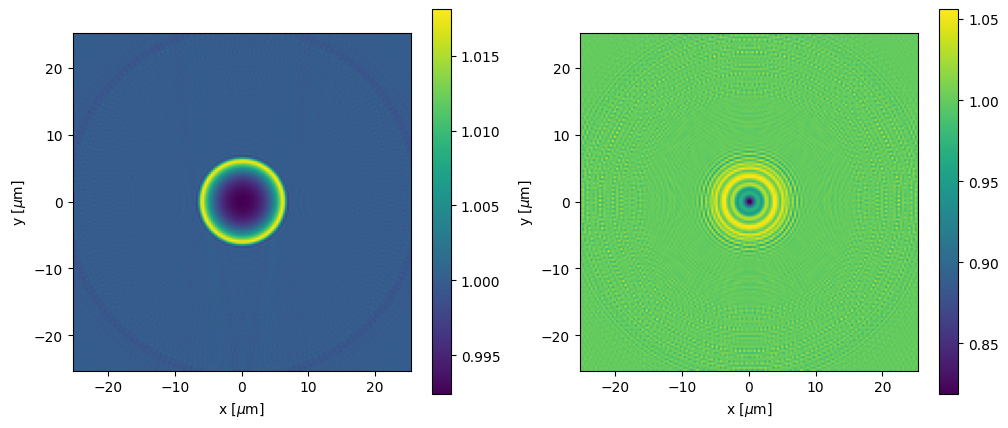

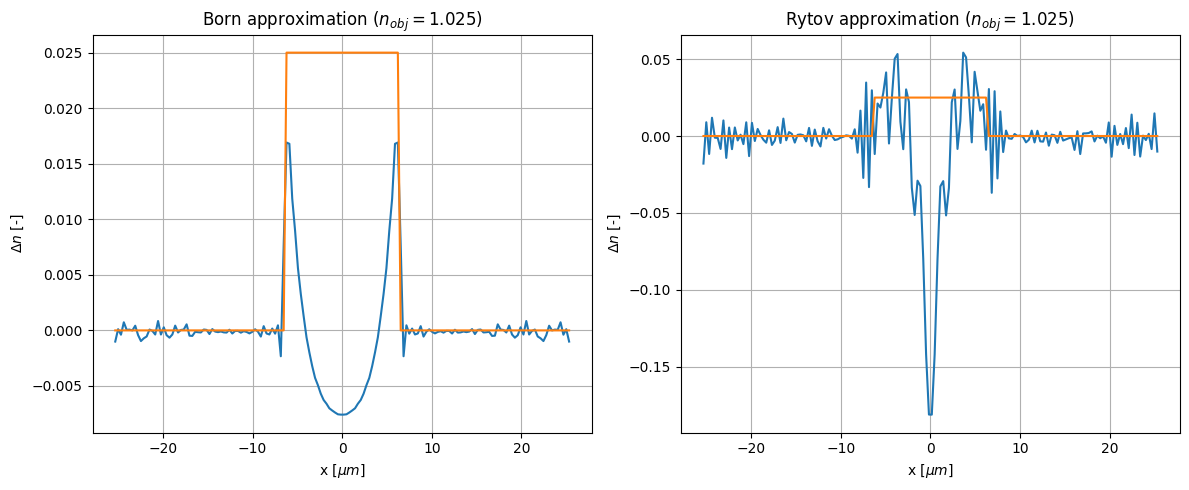

In [6]:
n_ideal_obj = np.where(RRR < R, n_obj + 0j, n_med + 0j)
n_ideal_obj = n_ideal_obj.swapaxes(0,1)
plt.rcParams['axes.formatter.useoffset'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

XZ_extent = [-Lx/2*10**6, Lx/2*10**6, -Lz/2*10**6, Lz/2*10**6]

pos1 = ax1.imshow(np.real(ri_field[:, Ny//2, :]), extent=XZ_extent)
ax1.set_xlabel("x [$\mu$m]")
ax1.set_ylabel("y [$\mu$m]")
plt.colorbar(pos1)

pos2 = ax2.imshow(np.real(ri_rytov[:, Ny//2, :]), extent=XZ_extent)
ax2.set_xlabel("x [$\mu$m]")
ax2.set_ylabel("y [$\mu$m]")
plt.colorbar(pos2)
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(x*10**6, np.real(ri_field[Nx//2, Ny//2, :])-1, label="Real part")
ax1.plot(x*10**6, np.real(n_ideal_obj[Nx//2, Ny//2, :])-1)
#ax1.plot(x*10**6, np.imag(ri_field[Nx//2, Ny//2, :]), label="Imaginairy part")
#ax1.plot(x*10**6, np.imag(n_ideal_obj[Nx//2, Ny//2, :]))
ax1.grid()
ax1.title.set_text("Born approximation ($n_{obj}=1.025$)")
ax1.set_ylabel("$\Delta n$ [-]")
ax1.set_xlabel("x [$\mu m$]")


ax2.plot(x*10**6, np.real(ri_rytov[:, Nx//2, Nx//2])-1, label="Real part")
ax2.plot(x*10**6, np.real(n_ideal_obj[:, Nx//2, Nx//2])-1)
#ax2.plot(x*10**6, np.imag(ri_rytov[:, Nx//2, Nx//2]), label="Imaginairy part")
#ax2.plot(x*10**6, np.imag(n_ideal_obj[:, Nx//2, Nx//2]))
ax2.grid()
ax2.title.set_text("Rytov approximation ($n_{obj}=1.025$)")
ax2.set_ylabel("$\Delta n$ [-]")
ax2.set_xlabel("x [$\mu m$]")

plt.tight_layout()
plt.show()